***
# Base Bi-LSTM Model using only 34k training and 10k of val of the original data of 90% training<br>
***

***
## 1 Load the train/val/test/balanced test datasets
emotions_with_neutrals_220228.csv concatenated the neutrals from Kaggle dataset<br>
https://github.com/dair-ai/emotion_dataset<br>
https://huggingface.co/datasets/dair-ai/emotion<br>

In [37]:
import pandas as pd
import numpy as np

# mount google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
# read from the google drive
project_folder = '/content/gdrive/MyDrive/266_Final_Project_Folder'

version = '_34k_10k'

train_source = project_folder + '/datasets/train_data_imbalanced_stratified_no_dupe' + version + '.csv'
test_source = project_folder + '/datasets/test_data_imbalanced_stratified_no_dupe.csv'
val_source = project_folder + '/datasets/validation_data_imbalanced_stratified_no_dupe' + version + '.csv'
balanced_test_source = project_folder + '/datasets/test_data_balanced_no_dupe.csv'

# Load the dfs
train_df = pd.read_csv(train_source)
test_df = pd.read_csv(test_source)
val_df = pd.read_csv(val_source)
balanced_test_df = pd.read_csv(balanced_test_source)

# drop the tweet_id column
train_df.drop(columns=train_df.columns[0], axis=1, inplace=True)
test_df.drop(columns=test_df.columns[0], axis=1, inplace=True)
val_df.drop(columns=val_df.columns[0], axis=1, inplace=True)
balanced_test_df.drop(columns=balanced_test_df.columns[0], axis=1, inplace=True)

### Confirm no overlapping records 

In [39]:
# Check if there are any records in train_df that are in val_df
overlap = train_df['text'].isin(val_df['text'])
print(f"Number of overlapping records, train-val: {overlap.sum()}")

# Check if there are any records in val_df that are in train_df
overlap = val_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, val-train: {overlap.sum()}")


# Check if there are any records in train_df that are in test_df
overlap = train_df['text'].isin(test_df['text'])
print(f"Number of overlapping records, train-test: {overlap.sum()}")

# Check if there are any records in test_df that are in train_df
overlap = test_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, test-train: {overlap.sum()}")


# Check if there are any records in train_df that are in balanced_test_df
overlap = train_df['text'].isin(balanced_test_df['text'])
print(f"Number of overlapping records, train-balanced test: {overlap.sum()}")

# Check if there are any records in train_df that are in balanced_test_df
overlap = balanced_test_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, balanced test, train: {overlap.sum()}")

Number of overlapping records, train-val: 0
Number of overlapping records, val-train: 0
Number of overlapping records, train-test: 0
Number of overlapping records, test-train: 0
Number of overlapping records, train-balanced test: 0
Number of overlapping records, balanced test, train: 0


In [40]:
train_df

,text,emotions
0,i am feeling really impatient,anger
1,i have a feeling that i am going to using thes...,joy
2,i feel like my life has just gotten considerab...,sadness
3,i had to sharpen up and concentrate and stop f...,joy
4,i just feel so strongly because of how loyal t...,love
...,...,...
34159,i am feeling very festive at the moment i thou...,joy
34160,i feel so proud of him and i am so grateful fo...,joy
34161,@daniellemhicks lol what!! where is it!,neutral
34162,i feel dirty is a theme for a href http www,sadness


In [41]:
val_df

,text,emotions
0,i have a list of things that i can do on any d...,joy
1,i feel very confident that you will get an awe...,joy
2,i feel radiant and sometimes,joy
3,i feel this section was the strongest in the b...,love
4,i feel somewhat messaging really artistic,joy
...,...,...
10245,i feel envious of them they have great jobs th...,anger
10246,i slept better slept more sound but was still ...,fear
10247,i have been irritable for no reason and i feel...,anger
10248,ive been feeling kind of gloomy and weird abou...,sadness


In [42]:
test_df

,text,emotions
0,i feel impatient to get moving forward,anger
1,i have decided to open wb to a few thoughtful ...,joy
2,i resolved at that moment to do my bit when i ...,sadness
3,i like his tip especially if you need assistan...,joy
4,i feel that if he did not want to be on the sh...,joy
...,...,...
37956,i am serving alongside other leaders in the de...,fear
37957,i am a little tipsy and feeling quite fond of ...,love
37958,i made my way to the front of the stage feelin...,fear
37959,i feel like nicholas is a really smart guy and...,joy


In [43]:
balanced_test_df

,text,emotions
0,i will get at the heart of the matter that you...,anger
1,i still feel selfish about it at times,anger
2,i feel a sarcastic emptyness and void in my life,anger
3,overeating a traditional type of food blood pu...,anger
4,i just have this feeling that im going to be b...,anger
...,...,...
6015,i am giving myself permission to feel funny aga,surprise
6016,i feel shocked angry confused,surprise
6017,im writing this blog post and feeling totally ...,surprise
6018,i feel this for all my grandchildren and with ...,surprise


***
## 2 Tokenizer

### Find the top word count (frequency > 10)
We'll use this number as our vocabulary size

In [44]:
# Split the text column into a list of words
words_df = train_df['text'].str.split().to_frame('words')

# Explode the list of words into separate rows
words_df = words_df.explode('words')

# Group by the words and count their occurrences
words_df = words_df.groupby('words').size().reset_index(name='count')
words_df

,words,count
0,!,3
1,!!,1
2,!!my,1
3,#Apple,1
4,#BGT,1
...,...,...
25033,|,1
25034,~,1
25035,ï¿½,1
25036,ï¿½WHYYY????????,1


In [45]:
# find the words with 'count' > 10
condition = words_df['count'] > 10

# sort the words based on count
new_words_df = words_df[condition].sort_values('count', ascending=False)
new_words_df

,words,count
11383,i,53887
8865,feel,23028
2084,and,19673
22451,to,18832
22122,the,17340
...,...,...
22665,trailer,11
9401,foundation,11
9508,friendships,11
22601,touching,11


In [46]:
# how many words are > 10?
top_word_count = len(new_words_df)
print('Vocabulary size:', top_word_count)

Vocabulary size: 3192


### Let's tokenize the train tweets!

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [48]:
tokenizer = Tokenizer(num_words=top_word_count, oov_token='<UNK>')
tokenizer.fit_on_texts(train_df['text']) # pass in tweets from training set

In [49]:
# this is what the tweet looks like as words
train_df['text'][0]

'i am feeling really impatient'

In [50]:
# this is what the tokenized version of the tweet looks like
tokenizer.texts_to_sequences([train_df['text'][0]])

[[2, 23, 8, 40, 565]]

(array([4.100e+01, 1.010e+02, 6.480e+02, 1.059e+03, 1.232e+03, 1.390e+03,
        1.369e+03, 1.404e+03, 1.309e+03, 1.334e+03, 1.417e+03, 1.294e+03,
        1.386e+03, 2.666e+03, 1.292e+03, 1.300e+03, 1.207e+03, 1.070e+03,
        1.048e+03, 9.590e+02, 9.020e+02, 8.050e+02, 8.220e+02, 7.250e+02,
        6.210e+02, 6.280e+02, 5.780e+02, 1.000e+03, 4.500e+02, 4.530e+02,
        3.460e+02, 3.430e+02, 3.090e+02, 2.650e+02, 2.700e+02, 2.480e+02,
        1.980e+02, 1.890e+02, 1.650e+02, 1.550e+02, 2.590e+02, 1.130e+02,
        1.250e+02, 8.900e+01, 7.700e+01, 8.200e+01, 6.500e+01, 4.700e+01,
        6.100e+01, 5.100e+01, 4.600e+01, 3.800e+01, 3.000e+01, 2.700e+01,
        2.400e+01, 9.000e+00, 7.000e+00, 4.000e+00, 4.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1.        ,  2.07352941,  3.14705882,  4.22058824,  5.29411765,
         6.36764706,  7.44117647,  8.51470588,  9.58823529, 10.66176471,
        

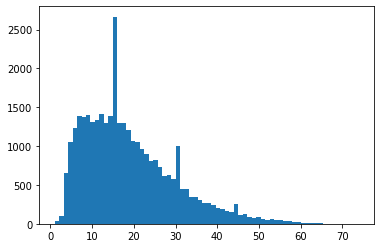

In [51]:
import matplotlib.pyplot as plt

# check to see what lenghts of the tweets in the dataset
lengths = [len(t.split(' ')) for t in train_df['text']]
plt.hist(lengths, bins=len(set(lengths)))

In [52]:
import statistics

# Apply the lambda function to the 'content' column and list called word_count_list'
word_count_list = list(train_df['text'].apply(lambda x: len(x.split(' '))))

# display the maximum and minimum lengths
print('Maximum word count:', max(word_count_list))
print('Minimum word count:', min(word_count_list))
print('Mean word count:', statistics.mean(word_count_list))
print('Median word count:', statistics.median(word_count_list))
print('75th percentile word count:', np.percentile(word_count_list, 75))
print('85th percentile word count:', np.percentile(word_count_list, 85))
print('95th percentile word count:', np.percentile(word_count_list, 95))

Maximum word count: 74
Minimum word count: 1
Mean word count: 18.91546657300082
Median word count: 17.0
75th percentile word count: 25.0
85th percentile word count: 30.0
95th percentile word count: 40.0


The max number of words is 101. We ultimately decided that we are going to keep all the words in the tweet. BERT can handle more than 200 so setting max_len = 200

***
## 3 Padding and truncating the training data sequences to make sure that the shape is the same for each string.

In [53]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [54]:
max_len = 200 # set the largest tweet size, >200 words -> truncate, <200 words -> pad

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len) # truncating happens at the end of the sequence (post)
  return padded # all examples will be the returned with same input size

In [55]:
padded_train_seq = get_sequences(tokenizer, train_df['text'])
padded_train_seq[0]

array([  2,  23,   8,  40, 565,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

***
## 4 Convert labels to numeric

### Function to convert text labels to numeric (reuse for all datasets)

In [56]:
# keeping this consistent for all models
class_to_index_dict = {'sadness': 0, 'anger': 1, 'fear': 2, 'surprise': 3, 'joy': 4, 'love': 5, 'neutral': 6}
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [57]:
def names_to_ids(class_to_index, data):
  return np.array([class_to_index.get(x) for x in data])

In [58]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
train_labels = names_to_ids(class_to_index_dict, train_df['emotions'])
print('train_df.iloc[7]:\n', train_df.iloc[index])
print('numeric label:', train_labels[index])

train_df.iloc[7]:
 text        i feel idiotic about it but i cant
emotions                               sadness
Name: 7, dtype: object
numeric label: 0


***
## 5 Create the model

In [59]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.11.0


In [60]:
# ref: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
# ref: https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# ref: https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras

# keep the vocabulary size the same as the base model, 11039
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=11039, output_dim=8, input_length=max_len),
    
    # the RNN part of the model
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)), # since using an LSTM layer inside a bidrectional layer, context can go in either direction; return_sequences=True means at every time step, there is an output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, )),

    tf.keras.layers.Dense(7, activation='softmax') # 7 for the seven classes

])

model.compile(
    loss='sparse_categorical_crossentropy', # since this is a multiclass classification problem, use categorical crossentropy; since classes are integers (not one hot encoded/binary), use sparse (just like in A3)
    optimizer='adam',
    metrics=['accuracy']
)

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 8)            88312     
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               1520      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 7)                 147       
                                                                 
Total params: 89,979
Trainable params: 89,979
Non-trainable params: 0
_________________________________________________________________


***
## 6 Train the model

### Convert the labels of the validation set to numeric (just like the training set)

In [62]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [63]:
val_seq = get_sequences(tokenizer, val_df['text'])
val_labels = names_to_ids(class_to_index_dict, val_df['emotions'])

In [64]:
# checking out the first input in validation sequence
val_seq[0], val_df['text'][0], val_df['emotions'][0]

(array([  2,  19,   7, 881,   9,  84,  10,   2,  42,  39,  29, 136,  92,
         10,   1,  83,  18,   3, 175,   4,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [65]:
print('val_df.iloc[0]:\n', val_df.iloc[0])
print('numeric label:', val_labels[0])

val_df.iloc[0]:
 text        i have a list of things that i can do on any d...
emotions                                                  joy
Name: 0, dtype: object
numeric label: 4


#### Check out the shape to make sure they're as expected

In [66]:
padded_train_seq.shape

(34164, 200)

In [67]:
train_labels.shape

(34164,)

In [68]:
val_seq.shape

(10250, 200)

In [69]:
val_labels.shape

(10250,)

### From Natalie's Notebook
https://github.com/datasci-w266/2023-spring-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb<br><br>
https://edstem.org/us/courses/32607/discussion/2699088?comment=6229916

#### Inspired by Natalie's notebook, made my own generator that chunks up my data into pieces that won't make my machine run out of memory before completing one epoch
If generator is not used, might delete this section

In [ ]:
# from sklearn.utils.random import sample_without_replacement

# # Define a generator function
# def generator(data, labels, batch_size):
#     # num_samples = len(data)
#     # while True:
#     #     indices = np.random.randint(num_samples, size=batch_size)
#     #     yield data[indices], labels[indices]

#     # Loop over batches
#     for i in range(0, len(data), batch_size):
      
#       # Get a batch of indices using sample_without_replacement()
#       batch_indices = sample_without_replacement(n_population=len(data), n_samples=batch_size)
      
#       # Yield a batch of features and labels using the indices
#       yield data[batch_indices], labels[batch_indices]

In [ ]:
# Create the generator
# batch_size = 1 # using this batch size because that's what seemed reasonable based on the number of records in the training dataset
# gen = generator(data=padded_train_seq, labels=train_labels, batch_size=batch_size)

#### Setting up checkpoints

In [ ]:
# reference: https://pynative.com/python-timezone/
# make a timestamp so it can be part of the folder name
# otherwise, all the checkpoints get dumped into the same
# folder and that's not great
import datetime
import pytz

local_tz = pytz.timezone('America/Denver')
local_dt = datetime.datetime.now(local_tz)

# Format the datetime object as a string without spaces
timestamp = local_dt.strftime('/%Y-%m-%d-%H%M')

# Print the string
print(timestamp)

/2023-03-09-2126


In [70]:
!ls '/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/'

17_5_model  archive  base_model


In [71]:
checkpoint_dir = project_folder + '/cm_working_dir/cm_checkpoints/17_5_model'
checkpoint_filepath = checkpoint_dir + '/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5' #+ timestamp + '/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [72]:
# check to make sure that the folder name is as expected
# format: .....cm_checkpoints/YYYY-MM-DD-TIME/....
print(checkpoint_filepath)

/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/17_5_model/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5


### Training the Model!!!

##### Uncomment cell below to load checkpoints; else keep commented to start fresh

In [ ]:
# uncomment below when loading checkpoints
# hdf5_checkpoint = 'weights.05-0.99' # change this to the right filename for the checkpoint
# checkpoint_filepath = checkpoint_dir + '/' + hdf5_checkpoint + '.hdf5'
# model.load_weights(checkpoint_filepath)

In [ ]:
# batch_size = 64
# steps_per_epoch = len(padded_train_seq) / batch_size

# history = model.fit(
#     gen,
#     validation_data=(val_seq, val_labels),
#     steps_per_epoch=steps_per_epoch,
#     epochs=1,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
#         model_checkpoint_callback
#     ]
# )

##### Training a fresh model (don't run this if running cells above)

In [73]:
batch_size = 64
steps_per_epoch = len(padded_train_seq) / batch_size

history = model.fit(
    # gen,
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
        model_checkpoint_callback
    ]
)

Epoch 1/5
533/533 [==============================] - 39s 55ms/step - loss: 1.4347 - accuracy: 0.4456 - val_loss: 0.8897 - val_accuracy: 0.7186
Epoch 2/5
533/533 [==============================] - 13s 25ms/step - loss: 0.6987 - accuracy: 0.7484 - val_loss: 0.6245 - val_accuracy: 0.7573
Epoch 3/5
533/533 [==============================] - 11s 20ms/step - loss: 0.5089 - accuracy: 0.8058 - val_loss: 0.4866 - val_accuracy: 0.8144
Epoch 4/5
533/533 [==============================] - 11s 20ms/step - loss: 0.3990 - accuracy: 0.8500 - val_loss: 0.4074 - val_accuracy: 0.8749
Epoch 5/5
533/533 [==============================] - 11s 21ms/step - loss: 0.3110 - accuracy: 0.9122 - val_loss: 0.3411 - val_accuracy: 0.9084


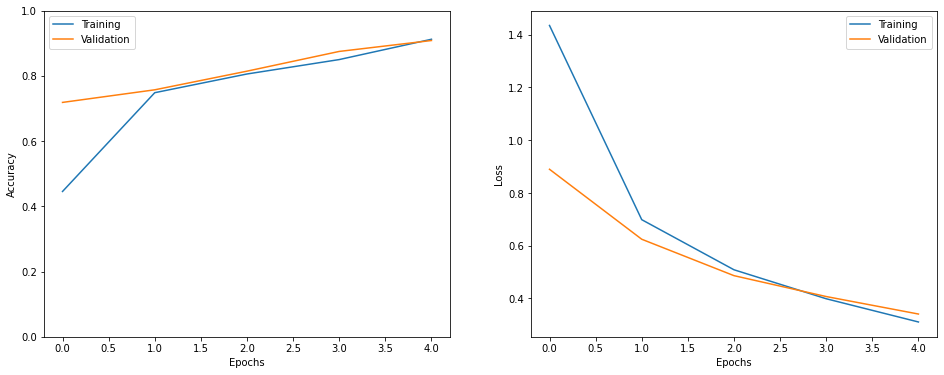

In [75]:
show_history(history)

***
## 7 Evaluate the model using imbalanced test_df

In [76]:
# borrowing this from A3 assignment, but turned it into a function
# classification report (cr) and confusion matrix (cm) from A3
from sklearn.metrics import classification_report
import seaborn as sns

def make_cr_cm(preds, labels):

  predictions_model = tf.argmax(preds, axis=-1)
  predictions_model

  # convert labels to string because classification_report needs target_names as str
  # labels are currently ints, but will change to str of in (i.e. '0', '1', etc)
  class_names = list(set([str(digit) for digit in labels]))

  # convert digits in target_names to the actual name of the emotion from the 
  # using class_to_index dictionary (i.e. '0' -> 'love', '5' -> 'neutral', etc.)
  class_names = [list(class_to_index_dict.keys())[list(class_to_index_dict.values()).index(int(name))] for name in class_names]

  print('Classification Report:\n\n', classification_report(labels, predictions_model.numpy(), target_names=class_names))

  print('Confusion Matrix:\n')
  
  # confusion matrix from A3
  cm = tf.math.confusion_matrix(labels, predictions_model)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(20,7))
  sns.heatmap(
      cm, annot=True,
      xticklabels=class_names,
      yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

### Padding the imbalanced test set for evaluation

In [77]:
padded_test_seq = get_sequences(tokenizer, test_df['text'])
padded_test_seq[0]

array([  2,   3, 565,   5,  57, 826, 737,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [78]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [79]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
test_labels = names_to_ids(class_to_index_dict, test_df['emotions'])
print('test_df.iloc[7]:\n', test_df.iloc[index])
print('numeric label:', test_labels[index])

test_df.iloc[7]:
 text        i never orgasm the feeling is lovely
emotions                                    love
Name: 7, dtype: object
numeric label: 5


### Evaluating the model using test_df!!!

In [80]:
model.evaluate(padded_test_seq, test_labels)

1187/1187 [==============================] - 10s 8ms/step - loss: 0.3432 - accuracy: 0.9043


[0.3431812524795532, 0.9043492078781128]

In [81]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_df.iloc[i])
print('Emotion:', test_labels[i])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        i feel very hopeful to be joining you at the f...
emotions                                                  joy
Name: 37379, dtype: object
Emotion: 4
1/1 [==============================] - 1s 679ms/step
Predicted Emotion: 4


In [82]:
preds_imbalanced_test_set = model.predict(padded_test_seq)

1187/1187 [==============================] - 8s 6ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:

               precision    recall  f1-score   support

        fear       0.91      0.96      0.94     11587
         joy       0.80      0.86      0.83      5226
     neutral       0.94      0.83      0.88      3955
     sadness       0.00      0.00      0.00       982
        love       0.95      0.97      0.96     12917
    surprise       0.88      0.89      0.88      2434
       anger       0.76      0.91      0.83       860

    accuracy                           0.90     37961
   macro avg       0.75      0.77      0.76     37961
weighted avg       0.88      0.90      0.89     37961

Confusion Matrix:



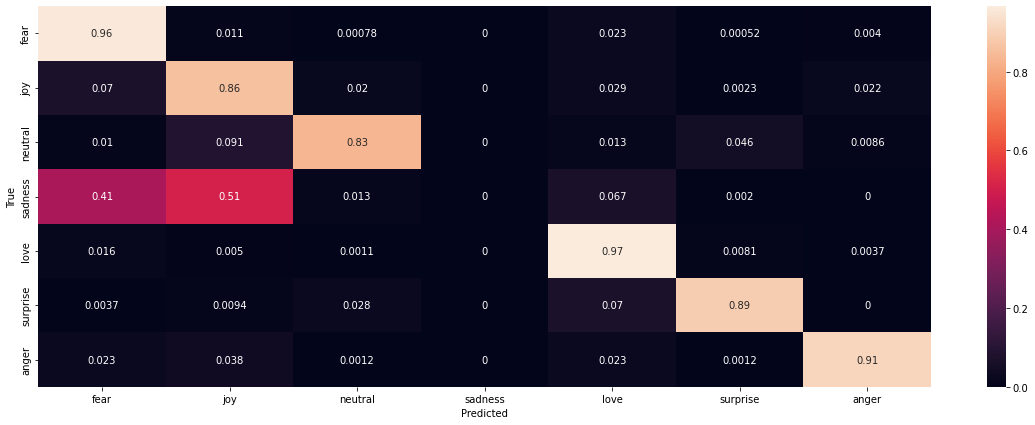

In [83]:
make_cr_cm(preds_imbalanced_test_set, test_labels)

***
## 8 Evaluating the model again, but with balanced_test_df!!!

### Padding the balanced test set for evaluation

In [84]:
padded_balanced_test_seq = get_sequences(tokenizer, balanced_test_df['text'])
padded_balanced_test_seq[0]

array([   2,   54,   57,   33,    6,  235,    9,    6,  620,   10,   31,
        111,   31,   66,   25,    4,    3,   59,    6,  235,   10, 1069,
         31,   37,  145,  708,    6, 2081,    9,  117,    1,    9,  113,
         31,  814, 1196,   18,    7,  921,  865,    1, 2178,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [85]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [86]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
balanced_test_labels = names_to_ids(class_to_index_dict, balanced_test_df['emotions'])
print('balanced_test_df.iloc[7]:\n', balanced_test_df.iloc[index])
print('numeric label:', balanced_test_labels[index])

balanced_test_df.iloc[7]:
 text        i feel like i m wronged
emotions                      anger
Name: 7, dtype: object
numeric label: 1


### Evaluating the model using balanced_test_df!!!

In [87]:
model.evaluate(padded_balanced_test_seq, balanced_test_labels)

189/189 [==============================] - 1s 7ms/step - loss: 0.6865 - accuracy: 0.7726


[0.6864609122276306, 0.7725913524627686]

In [88]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(balanced_test_labels) - 1)

print('Sentence:', balanced_test_df.iloc[i])
print('Emotion:', balanced_test_labels[i])

p = model.predict(np.expand_dims(padded_balanced_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        i felt even more frustrated and discouraged wh...
emotions                                                anger
Name: 198, dtype: object
Emotion: 1
1/1 [==============================] - 0s 22ms/step
Predicted Emotion: 0


In [89]:
preds_balanced_test_set = model.predict(padded_balanced_test_seq)

189/189 [==============================] - 1s 6ms/step


Classification Report:

               precision    recall  f1-score   support

        fear       0.64      0.96      0.77       860
         joy       0.56      0.86      0.68       860
     neutral       0.93      0.83      0.87       860
     sadness       0.00      0.00      0.00       860
        love       0.81      0.97      0.88       860
    surprise       0.94      0.89      0.91       860
       anger       0.96      0.91      0.94       860

    accuracy                           0.77      6020
   macro avg       0.69      0.77      0.72      6020
weighted avg       0.69      0.77      0.72      6020

Confusion Matrix:



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


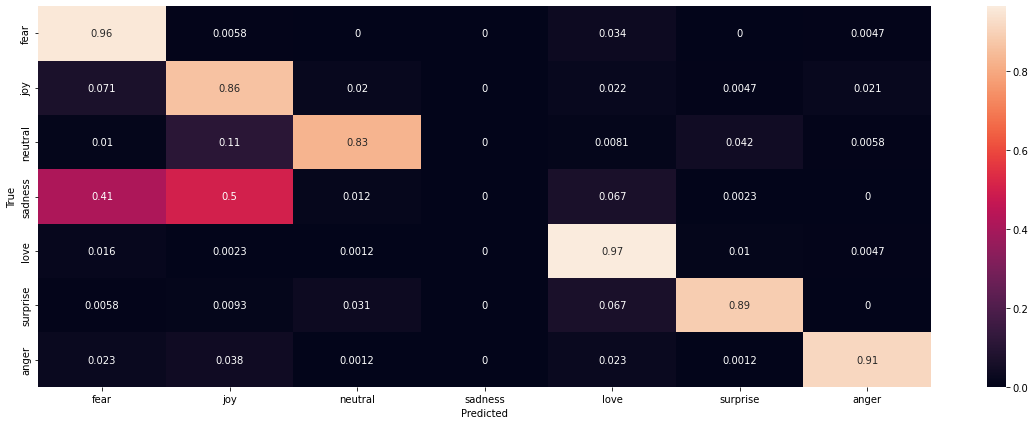

In [90]:
make_cr_cm(preds_balanced_test_set, balanced_test_labels)